#Instructions

This file runs all experiments for paragraph retrieval presented in my thesis: *Covid-19: We might need to check that!*. The results for the experiments are:

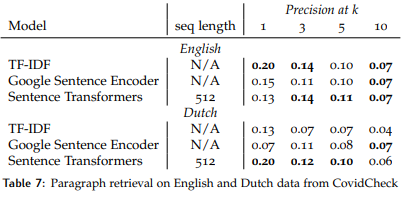

If you would like to reproduce these results, follow these steps:

1.   If you are using Google Colab mount the Drive to the folder where you have all Github files stored. Otherwise cd to the folder where you have all Github files stored.
2.   Under the chapter **Data loading and pre-processing** set *dir* to be either *wiki_annotation_pages/en/* if you'd like to do experiments using the English Wikipedia pages or *wiki_annotation_pages/nl/* if you'd like to do experiments using the Dutch Wikipedia pages.
3.   Under the chapter **Import CovidCheck** set the give *read_csv* argument to *covidcheck_en.csv* if you'd like to do experiments using the English part of CovidCheck or *covidcheck_nl.csv* if you'd like to do experiments using the Dutch part of CovidCheck.
4.   Run all cells under **Imports and Data**.
5.   Run the cells for your desired model (TF-IDF, Google Sentence encoder or Sentence transformers). You can only run experiments for one model at a time. If you'd like to use a different model, simply run the cells for the model you'd like to do your following experiments with.
6.   Under **Run experiment** provide the model you'd like to do your experiment with (either *tf-idf*, *google_sentence_encoder* or *sentence_transformers*) and the precision at k (for example *1* or *5*).
7.   Run the cells under **Scoring**. Your results should be *Score: y out of x*.
8.   To get the precision at k score: y/x.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
%cd gdrive/MyDrive/Remi/

Mounted at /content/gdrive
/content/gdrive/.shortcut-targets-by-id/1WJLnwO7mUn1QFbhFIJ6fMZjZWuCKf1ub/Remi


#Imports and Data

##Imports

In [2]:
!pip3 install tensorflow-hub
!pip3 install tensorflow-text
import tensorflow_text
!pip3 install -U sentence-transformers

import pandas as pd
import nltk
import scipy
import numpy as np
import os 
import re
import pickle
import nltk 

import re
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import tensorflow
from tqdm._tqdm_notebook import tqdm_notebook
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import defaultdict
from nltk.corpus import wordnet as wn
import os.path
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import TfidfVectorizer
import operator

nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('punkt')
tqdm_notebook.pandas()
nltk.download('punkt')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.9 MB 4.8 MB/s 
     |████████████████████████████████| 578.0 MB 19 kB/s 
     |████████████████████████████████| 1.7 MB 51.6 MB/s 
     |████████████████████████████████| 438 kB 76.2 MB/s 
     |████████████████████████████████| 5.9 MB 40.2 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstall

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Data loading and pre-processing

In [3]:
i = 0
dfs = []
# Wiki pages that are used -> can be either wiki_annotation_pages/en/ or wiki_annotation_pages/nl/
dir = 'wiki_annotation_pages/en/'
for filename in os.listdir(dir):
    data = pd.read_json(dir + filename)  
    data = data["query"]["pages"][0]
    filename = filename.replace('.json', '')
    data.update({'filename': filename})
    data = pd.DataFrame([data])
    dfs.append(data)

temp = pd.concat(dfs, ignore_index=True)
temp.rename(columns={'title':'Subject'}, inplace=True)
temp.rename(columns={'extract':'content'}, inplace=True)

df_wikipedia =temp[['Subject','content', 'filename']]
df_wikipedia.content =df_wikipedia.content.replace(to_replace='<p(.*?)>',value='<p>',regex=True)
df_wikipedia.content =df_wikipedia.content.replace(to_replace='<link(.*?)>',value=' ',regex=True)
df_wikipedia.content =df_wikipedia.content.replace(to_replace='-',value=' ',regex=True)
df_wikipedia.content =df_wikipedia.content.replace(to_replace='  ',value='',regex=True)
df_wikipedia.content =df_wikipedia.content.apply(lambda x:x.strip())

# Data cleaning for subject data 
df_wikipedia.Subject =df_wikipedia.Subject.replace(to_replace='[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]',value=' ',regex=True)
df_wikipedia.Subject =df_wikipedia.Subject.replace(to_replace='\s+',value=' ',regex=True)
df_wikipedia.Subject =df_wikipedia.Subject.replace(to_replace='  ',value='',regex=True)
df_wikipedia.Subject =df_wikipedia.Subject.apply(lambda x:x.strip())
df_wikipedia.content =df_wikipedia.content.replace(to_replace='<p> </p>',value='',regex=True)

# Content splitting
df_wikipedia["content"]=df_wikipedia["content"].str.split("\n<p>")
df_wikipedia = df_wikipedia.explode("content").reset_index(drop=True)
df_wikipedia["content"]=df_wikipedia["content"].str.split("</p>\s+<h")
df_wikipedia = df_wikipedia.explode("content").reset_index(drop=True)
df_wikipedia["content"]=df_wikipedia["content"].str.split("\n</p>\n")
df_wikipedia = df_wikipedia.explode("content").reset_index(drop=True)
df_wikipedia["content"]=df_wikipedia["content"].str.split("</li></ul><h3(.*?)>")
df_wikipedia = df_wikipedia.explode("content").reset_index(drop=True)
df_wikipedia["content"]=df_wikipedia["content"].str.split("\n</ul><h4>")
df_wikipedia = df_wikipedia.explode("content").reset_index(drop=True)
df_wikipedia["content"]=df_wikipedia["content"].str.split("</h3>\s+<ul><li>")
df_wikipedia = df_wikipedia.explode("content").reset_index(drop=True)

df_wikipedia['content']=[entry.lower() for entry in df_wikipedia['content']]
SW=['<span>', '<li>', '</li>', '<ul>', '</ul>', '<b>', '</b>', '</i>']
for sw in SW:
    df_wikipedia.content=df_wikipedia.content.replace(to_replace=sw,value='',regex=True)

df_wikipedia.content =df_wikipedia.content.replace(to_replace='\n',value=' ',regex=True)
df_wikipedia.content =df_wikipedia.content.replace(to_replace='<\/p>\s+<h(.*?)</h(.*?)>',value='',regex=True)  

# Remove unnecessary characters
df_wikipedia = df_wikipedia[df_wikipedia.content != ' ']
df_wikipedia.content =df_wikipedia.content.replace(to_replace='[!"#$%&\'()*+,:;=?@[\\]^_`{|}~]',value=' ',regex=True)
df_wikipedia.content =df_wikipedia.content.replace(to_replace='<[^<]+?>',value=' ',regex=True)
df_wikipedia.content =df_wikipedia.content.replace(to_replace='\s+',value=' ',regex=True)
df_wikipedia.content =df_wikipedia.content.replace(to_replace='  ',value=' ',regex=True)

df_wikipedia = df_wikipedia[~df_wikipedia['content'].str.startswith('2>')]
df_wikipedia = df_wikipedia[~df_wikipedia['content'].str.startswith('3>')]
df_wikipedia = df_wikipedia[~df_wikipedia['content'].str.startswith('4>')]
df_wikipedia = df_wikipedia[~df_wikipedia['content'].str.startswith('5>')]

df_wikipedia = df_wikipedia.reset_index(drop=True)
df_wikipedia = df_wikipedia.loc[df_wikipedia['content'].str.len() > 1]
df_wikipedia = df_wikipedia.reset_index(drop=True)

df_wikipedia["tokenized"] = df_wikipedia["content"]

# Amount of words in data:
nli = df_wikipedia["content"].to_list()
all_words = []
for paragraph in nli:
  if type(paragraph) == str:
    words = paragraph.split()
    for word in words:
      all_words.append(word)

print(all_words[:10])
print(len(all_words))

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


['india', 'began', 'administration', 'of', 'covid', '19', 'vaccines', 'on', '16', 'january']
170191


### CovidCheck

In [4]:
covid_check = pd.read_csv('covidcheck_en.csv', sep=',')
covid_check['tokenized_covidcheck'] = covid_check['verify_text']

covid_check['tokenized_covidcheck']= covid_check['tokenized_covidcheck'].str.lower()
SW=['<span>', '<li>', '</li>', '<ul>', '</ul>', '<b>', '</b>', '<h4>', '</h4>', '<h3>', '</h3>', '<h2>', '</h2>', '<h1>', '</h1>', '</link>', '</span>', '</i>']
for sw in SW:
    covid_check.tokenized_covidcheck=covid_check.tokenized_covidcheck.replace(to_replace=sw,value='',regex=True)

covid_check.tokenized_covidcheck =covid_check.tokenized_covidcheck.replace(to_replace='<p(.*?)>',value='<p>',regex=True)
covid_check.tokenized_covidcheck =covid_check.tokenized_covidcheck.replace(to_replace='<link(.*?)>',value=' ',regex=True)
covid_check.tokenized_covidcheck =covid_check.tokenized_covidcheck.replace(to_replace='<span(.*?)>',value=' ',regex=True)
covid_check.tokenized_covidcheck =covid_check.tokenized_covidcheck.replace(to_replace='<i(.*?)>',value=' ',regex=True)
covid_check.tokenized_covidcheck =covid_check.tokenized_covidcheck.replace(to_replace='[!"#$%&\'()*+,:;=?@[\\]^_`{|}~]',value=' ',regex=True)
covid_check.tokenized_covidcheck =covid_check.tokenized_covidcheck.replace(to_replace='-',value=' ',regex=True)
covid_check.tokenized_covidcheck =covid_check.tokenized_covidcheck.apply(lambda x:x.strip() if type(x) == str else x)

covid_check["tokenized_covidcheck"] = covid_check["tokenized_covidcheck"].str.split("<p>")
covid_check = covid_check.explode("tokenized_covidcheck").reset_index(drop=True)
covid_check = covid_check[covid_check.tokenized_covidcheck != ' ']
covid_check.tokenized_covidcheck =covid_check.tokenized_covidcheck.replace(to_replace='<[^<]+?>',value=' ',regex=True)
covid_check.tokenized_covidcheck =covid_check.tokenized_covidcheck.replace(to_replace='  ',value=' ',regex=True)
covid_check["tokenized"] = covid_check["tokenized_covidcheck"]

print(covid_check.head(10))

   Unnamed: 0     topic             tweet_id  \
0           0  COVID-19  1368273275181207552   
1           1  COVID-19  1369369392052637696   
2           2  COVID-19  1368254297704595456   
3           3  COVID-19  1369877253849411584   
4           4  COVID-19  1367982412332900352   
5           5  COVID-19  1354009455378182144   
6           6  COVID-19  1367834808353656832   
7           7  COVID-19  1370393398239240192   
8           8  COVID-19  1367919128338591744   
9           9  COVID-19  1371069095831998464   

                                           tweet_url  \
0  http://twitter.com/user/status/136827327518120...   
1  http://twitter.com/user/status/136936939205263...   
2  http://twitter.com/user/status/136825429770459...   
3  http://twitter.com/user/status/136987725384941...   
4  http://twitter.com/user/status/136798241233290...   
5  http://twitter.com/user/status/135400945537818...   
6  http://twitter.com/user/status/136783480835365...   
7  http://twitter.com/u

#TF-IDF

In [5]:
df_wikipedia['Word tokenize']= [word_tokenize(entry) for entry in df_wikipedia.tokenized]

### Word Lemmatization

In [6]:
# WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
def wordLemmatizer(data):
    tag_map = defaultdict(lambda : wn.NOUN)
    tag_map['J'] = wn.ADJ
    tag_map['V'] = wn.VERB
    tag_map['R'] = wn.ADV
    file_clean_k =pd.DataFrame()
    for index,entry in enumerate(data):
        
        # Declaring Empty List to store the words that follow the rules for this step
        Final_words = []
        # Initializing WordNetLemmatizer()
        word_Lemmatized = WordNetLemmatizer()
        # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
        for word, tag in pos_tag(entry):
            # Below condition is to check for Stop words and consider only alphabets
            if len(word)>1 and word not in stopwords.words('english') and word.isalpha():
                word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
                Final_words.append(word_Final)
            # The final processed set of words for each iteration will be stored in 'text_final'
                file_clean_k.loc[index,'Keyword_final'] = str(Final_words)
                file_clean_k.loc[index,'Keyword_final'] = str(Final_words)
    return file_clean_k

In [7]:
df_wikipedia.shape 

(989, 5)

In [8]:
df_wikipedia

,Subject,content,filename,tokenized,Word tokenize
0,COVID 19 vaccination in India,india began administration of covid 19 vaccine...,COVID-19_vaccination_in_India,india began administration of covid 19 vaccine...,"[india, began, administration, of, covid, 19, ..."
1,COVID 19 vaccination in India,total doses administered across the country as...,COVID-19_vaccination_in_India,total doses administered across the country as...,"[total, doses, administered, across, the, coun..."
2,COVID 19 vaccination in India,monthly graph of cumulative doses administered...,COVID-19_vaccination_in_India,monthly graph of cumulative doses administered...,"[monthly, graph, of, cumulative, doses, admini..."
3,COVID 19 vaccination in India,graph of daily doses administered. last update...,COVID-19_vaccination_in_India,graph of daily doses administered. last update...,"[graph, of, daily, doses, administered, ., las..."
4,COVID 19 vaccination in India,vaccinations in india by gender as of july 9 2022,COVID-19_vaccination_in_India,vaccinations in india by gender as of july 9 2022,"[vaccinations, in, india, by, gender, as, of, ..."
...,...,...,...,...,...
984,List of COVID 19 vaccine authorizations,full 1 canada emergency 0 travel only malaysi...,List_of_COVID-19_vaccine_authorizations,full 1 canada emergency 0 travel only malaysi...,"[full, 1, canada, emergency, 0, travel, only, ..."
985,List of COVID 19 vaccine authorizations,noora is a protein based vaccine developed by ...,List_of_COVID-19_vaccine_authorizations,noora is a protein based vaccine developed by ...,"[noora, is, a, protein, based, vaccine, develo..."
986,List of COVID 19 vaccine authorizations,full 0 emergency 1 iran travel only malaysia ...,List_of_COVID-19_vaccine_authorizations,full 0 emergency 1 iran travel only malaysia ...,"[full, 0, emergency, 1, iran, travel, only, ma..."
987,List of COVID 19 vaccine authorizations,skycovione is a protein subunit vaccine develo...,List_of_COVID-19_vaccine_authorizations,skycovione is a protein subunit vaccine develo...,"[skycovione, is, a, protein, subunit, vaccine,..."


In [9]:
df_clean = wordLemmatizer(df_wikipedia['Word tokenize'][0:989]) 
df_clean

,Keyword_final
0,"['india', 'begin', 'administration', 'covid', ..."
1,"['total', 'dos', 'administer', 'across', 'coun..."
2,"['monthly', 'graph', 'cumulative', 'dos', 'adm..."
3,"['graph', 'daily', 'dos', 'administer', 'last'..."
4,"['vaccination', 'india', 'gender', 'july']"
...,...
984,"['full', 'canada', 'emergency', 'travel', 'mal..."
985,"['noora', 'protein', 'base', 'vaccine', 'devel..."
986,"['full', 'emergency', 'iran', 'travel', 'malay..."
987,"['skycovione', 'protein', 'subunit', 'vaccine'..."


In [10]:
df_clean=df_clean.replace(to_replace ="\[.", value = '', regex = True)
df_clean=df_clean.replace(to_replace ="'", value = '', regex = True)
df_clean=df_clean.replace(to_replace =" ", value = '', regex = True)
df_clean=df_clean.replace(to_replace ='\]', value = '', regex = True)

### Added WordLemmatize words into given dataframe

In [11]:
df_wikipedia.insert(loc=3, column='Clean_Keyword', value=df_clean['Keyword_final'].tolist())
df_wikipedia_save= df_wikipedia
df_wikipedia_save

,Subject,content,filename,Clean_Keyword,tokenized,Word tokenize
0,COVID 19 vaccination in India,india began administration of covid 19 vaccine...,COVID-19_vaccination_in_India,"india,begin,administration,covid,vaccine,janua...",india began administration of covid 19 vaccine...,"[india, began, administration, of, covid, 19, ..."
1,COVID 19 vaccination in India,total doses administered across the country as...,COVID-19_vaccination_in_India,"total,dos,administer,across,country,july",total doses administered across the country as...,"[total, doses, administered, across, the, coun..."
2,COVID 19 vaccination in India,monthly graph of cumulative doses administered...,COVID-19_vaccination_in_India,"monthly,graph,cumulative,dos,administer,across...",monthly graph of cumulative doses administered...,"[monthly, graph, of, cumulative, doses, admini..."
3,COVID 19 vaccination in India,graph of daily doses administered. last update...,COVID-19_vaccination_in_India,"graph,daily,dos,administer,last,updated,july",graph of daily doses administered. last update...,"[graph, of, daily, doses, administered, ., las..."
4,COVID 19 vaccination in India,vaccinations in india by gender as of july 9 2022,COVID-19_vaccination_in_India,"vaccination,india,gender,july",vaccinations in india by gender as of july 9 2022,"[vaccinations, in, india, by, gender, as, of, ..."
...,...,...,...,...,...,...
984,List of COVID 19 vaccine authorizations,full 1 canada emergency 0 travel only malaysi...,List_of_COVID-19_vaccine_authorizations,"full,canada,emergency,travel,malaysia,new,zeal...",full 1 canada emergency 0 travel only malaysi...,"[full, 1, canada, emergency, 0, travel, only, ..."
985,List of COVID 19 vaccine authorizations,noora is a protein based vaccine developed by ...,List_of_COVID-19_vaccine_authorizations,"noora,protein,base,vaccine,develop,baqiyatalla...",noora is a protein based vaccine developed by ...,"[noora, is, a, protein, based, vaccine, develo..."
986,List of COVID 19 vaccine authorizations,full 0 emergency 1 iran travel only malaysia ...,List_of_COVID-19_vaccine_authorizations,"full,emergency,iran,travel,malaysia,turkey,sky...",full 0 emergency 1 iran travel only malaysia ...,"[full, 0, emergency, 1, iran, travel, only, ma..."
987,List of COVID 19 vaccine authorizations,skycovione is a protein subunit vaccine develo...,List_of_COVID-19_vaccine_authorizations,"skycovione,protein,subunit,vaccine,develop,sk,...",skycovione is a protein subunit vaccine develo...,"[skycovione, is, a, protein, subunit, vaccine,..."


## The Model

In [12]:
## Create Vocabulary
vocabulary = set()

for doc in df_wikipedia.Clean_Keyword:
    vocabulary.update(doc.split(','))

vocabulary = list(vocabulary)

# Intializating the tfIdf model
tfidf = TfidfVectorizer(vocabulary=vocabulary,dtype=np.float32)

print(tfidf)

# Fit the TfIdf model
tfidf.fit(df_wikipedia.Clean_Keyword)

# Transform the TfIdf model
tfidf_tran=tfidf.transform(df_wikipedia.Clean_Keyword)

TfidfVectorizer(dtype=<class 'numpy.float32'>,
                vocabulary=['manafort', 'vitally', 'arbutus', 'collaborator',
                            'seek', 'tremelimumab', 'hometown', 'influence',
                            'accrue', 'formulation', 'us', 'danger',
                            'altercation', 'territorial', 'aborted',
                            'bedfordshire', 'error', 'keen', 'kingdom',
                            'rebecca', 'louie', 'meaning', 'tin', 'stated',
                            'aseptic', 'point', 'northwestern', 'positioning',
                            'fame', 'schulz', ...])


In [13]:
def gen_vector_T(tokens):
    Q = np.zeros((len(vocabulary)))
    x= tfidf.transform(tokens)
    for token in tokens[0].split(','):
        try:
            ind = vocabulary.index(token)
            Q[ind]  = x[0, tfidf.vocabulary_[token]]
        except:
            pass
    return Q

In [14]:
def cosine_sim(a, b):
    cos_sim = np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))
    return cos_sim

In [15]:
def cosine_similarity_T(k, query):
    #print("Cosine Similarity")
    preprocessed_query = re.sub("\W+", " ", query).strip()
    tokens = word_tokenize(str(preprocessed_query))
    q_df = pd.DataFrame(columns=['q_clean'])
    q_df.loc[0,'q_clean'] =tokens
    q_df['q_clean'] =wordLemmatizer(q_df.q_clean)
    q_df=q_df.replace(to_replace ="\[.", value = '', regex = True)
    q_df=q_df.replace(to_replace ="'", value = '', regex = True)
    q_df=q_df.replace(to_replace =" ", value = '', regex = True)
    q_df=q_df.replace(to_replace ='\]', value = '', regex = True)

    d_cosines = []

    query_vector = gen_vector_T(q_df['q_clean'])
    
    print(query_vector)
    for d in tfidf_tran.A:
        
        d_cosines.append(cosine_sim(query_vector, d))
                    
    out = np.array(d_cosines).argsort()[-k:][::-1]
    #print("")
    d_cosines.sort()
    #print(out)
    a = pd.DataFrame()
    for i,index in enumerate(out):
        a.loc[i,'index'] = str(index)
        a.loc[i,'Subject'] = df_wikipedia['Subject'][index]
        a.loc[i,'content'] = df_wikipedia['content'][index]
    for j,simScore in enumerate(d_cosines[-k:][::-1]):
        a.loc[j,'Score'] = simScore
    return a

# Test query
%time cosine_similarity_T(10,'johnson and johnson vaccines derived from murdered babies. at least 2 other vaccines are not. if you take vaccines use those.')

[0. 0. 0. ... 0. 0. 0.]
CPU times: user 86.8 ms, sys: 68.7 ms, total: 155 ms
Wall time: 112 ms


,index,Subject,content,Score
0,77,Janssen COVID 19 vaccine,in december 2020 johnson amp johnson and reig ...,0.499014
1,86,Janssen COVID 19 vaccine,on 11 february 2021 saint vincent and the gren...,0.441868
2,89,Janssen COVID 19 vaccine,given the janssen vaccine is a single dose and...,0.405219
3,80,Janssen COVID 19 vaccine,johnson amp johnson subsidiary janssen vaccine...,0.339200
4,76,Janssen COVID 19 vaccine,unpunctured vials may be stored between 9 to 2...,0.337864
5,79,Janssen COVID 19 vaccine,the stabilized version of the spike protein – ...,0.334450
6,70,Janssen COVID 19 vaccine,the janssen covid‑19 vaccine sold under the br...,0.306042
7,20,COVID 19 vaccination in India,in september 2021 india s government announced...,0.255537
8,0,COVID 19 vaccination in India,india began administration of covid 19 vaccine...,0.231835
9,108,COVID 19 vaccine,internationally the access to covid‑19 tools a...,0.213963


#Google Sentence Encoder

In [20]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder-multilingual/3"
model = hub.load(module_url)

# # #Create function for using modeltraining
def embed(input):
    return model(input)


Model_USE= embed(df_wikipedia['tokenized'])

exported = tf.train.Checkpoint(v=tf.Variable(Model_USE))
exported.f = tf.function(
    lambda  x: exported.v * x,
    input_signature=[tf.TensorSpec(shape=None, dtype=tf.float32)])

tf.saved_model.save(exported,'TrainModel')

imported = tf.saved_model.load('TrainModel')
loadedmodel =imported.v.numpy()
loadedmodel.shape

def SearchDocument(query):
    q =[query]
    # embed the query for calcluating the similarity
    Q_Train =embed(q)

    # Calculate the Similarity
    linear_similarities = linear_kernel(Q_Train, loadedmodel).flatten() 
    #Sort top 10 index with similarity score
    Top_index_doc = linear_similarities.argsort()[:-11:-1]
    # sort by similarity score
    linear_similarities.sort()
    a = pd.DataFrame()
    for i,index in enumerate(Top_index_doc):
        a.loc[i,'index'] = str(index)
        a.loc[i,'File_Name'] = df_wikipedia['content'][index]
    for j,simScore in enumerate(linear_similarities[:-11:-1]):
        a.loc[j,'Score'] = simScore
    return a

# Test Query
SearchDocument('Together with collaborators, we founded a spinout company to develop and commercialise a nasal spray vaccine against COVID. The vaccine is based on research by our and @UniEastFinland researchers. #HelsinkiHealth #corona #COVID19 #covidvaccine')

,index,File_Name,Score
0,935,the vaccine is marketed under the brand name c...,0.666144
1,125,michael yeadon is a british anti vaccine acti...,0.643103
2,99,inactivated vaccines consist of virus particle...,0.625157
3,175,following the september 11 attacks of 2001 and...,0.610309
4,70,the janssen covid‑19 vaccine sold under the br...,0.604783
5,409,an mrna vaccine or rna vaccine is a novel type...,0.601729
6,917,the vaccine arose from a collaboration between...,0.591922
7,104,a universal coronavirus vaccine is effective a...,0.589395
8,200,four covid 19 vaccines have been approved by t...,0.588212
9,98,these vaccines are examples of non replicating...,0.584928


#Sentence Transformers

In [ ]:
model = SentenceTransformer('sentence-transformers/distiluse-base-multilingual-cased-v2')

def embed(input):
    return model(input)

model.max_seq_length = 512
print("Max Sequence Length:", model.max_seq_length)
embeddings = model.encode(df_wikipedia['content'])

def SearchDocument(query):
    q =[query]
    # embed the query for calcluating the similarity
    Q_Train = model.encode(q)

    # Calculate the Similarity
    linear_similarities = scipy.spatial.distance.cdist(Q_Train, embeddings, "cosine")[0]
    linear_similarities = 1 - linear_similarities
    #Sort top 10 index with similarity score
    Top_index_doc = linear_similarities.argsort()[:-11:-1]
    # sort by similarity score
    linear_similarities.sort()
    a = pd.DataFrame()
    for i,index in enumerate(Top_index_doc):
        a.loc[i,'index'] = str(index)
        a.loc[i,'Content'] = df_wikipedia['content'][index]
        a.loc[i,'File name'] = df_wikipedia['filename'][index]
    for j,simScore in enumerate(linear_similarities[:-11:-1]):
        a.loc[j,'Score'] = simScore
    return a

# Test Query
SearchDocument('Together with collaborators, we founded a spinout company to develop and commercialise a nasal spray vaccine against COVID. The vaccine is based on research by our and @UniEastFinland researchers. #HelsinkiHealth #corona #COVID19 #covidvaccine')

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/114 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.38k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/610 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/539M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/531 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/341 [00:00<?, ?B/s]

Max Sequence Length: 512


,index,Content,File name,Score
0,917,the vaccine arose from a collaboration between...,Oxford-AstraZeneca_COVID-19_vaccine,0.570668
1,683,in january 2020 moderna announced development ...,Moderna_COVID-19_vaccine,0.537400
2,983,covlp is a virus like particle vaccine grown i...,List_of_COVID-19_vaccine_authorizations,0.525662
3,966,full 4 australia canada japan south korea cov...,List_of_COVID-19_vaccine_authorizations,0.497111
4,981,sinopharm cnbg covid 19 vaccine nvsi is a reco...,List_of_COVID-19_vaccine_authorizations,0.496829
5,124,protocol mrna 1273 p301 pdf . moderna. protoc...,COVID-19_vaccine,0.496551
6,104,a universal coronavirus vaccine is effective a...,COVID-19_vaccine,0.490719
7,935,the vaccine is marketed under the brand name c...,Oxford-AstraZeneca_COVID-19_vaccine,0.472500
8,175,following the september 11 attacks of 2001 and...,Nasal_vaccine,0.466850
9,122,in june 2021 a report revealed that the ub 612...,COVID-19_vaccine,0.463849


# Scoring

In [28]:
def first_last_words(cur_list):
    fl_sentence = ''
    fl_list = []
    for sentence in cur_list:
      sent_list = sentence.split()
      if len(sent_list) > 3:
        fl_sentence = '{} {} {} {}'.format(sent_list[0], sent_list[1], sent_list[-2], sent_list[-1])
      elif len(sent_list) > 1:
        fl_sentence = sent_list[0]
      else:
        fl_sentence = None
      fl_list.append(fl_sentence)
    return fl_list

def similarity_huggingface(query):
  # Calculatte similarity for huggingface models
  Q_Train = model.encode(q)
  linear_similarities = scipy.spatial.distance.cdist(Q_Train, embeddings, "cosine")[0]
  linear_similarities = 1 - linear_similarities
  return linear_similarities

def similarity_tfhub(query):
  # Calculatte similarity for Tensorflow Hub models
  Q_Train =embed(query)
  #linear_similarities = linear_kernel(Q_Train, loadedmodel).flatten()
  linear_similarities = scipy.spatial.distance.cdist(Q_Train, loadedmodel, "cosine")[0]
  linear_similarities = 1 - linear_similarities
  return linear_similarities

def tfidf_similarity(k):
  index = 0
  matches = 0
  total = 0
  for checkworthy in covid_check['class_label']:
    correct_docs = []
    if checkworthy == 1:
      # input check-worthy message
      query = covid_check['tweet_text'][index]
      preprocessed_query = re.sub("\W+", " ", query).strip()
      tokens = word_tokenize(str(preprocessed_query))

      q_df = pd.DataFrame(columns=['q_clean'])
      q_df.loc[0,'q_clean'] =tokens
      q_df['q_clean'] =wordLemmatizer(q_df.q_clean)
      q_df=q_df.replace(to_replace ="\[.", value = '', regex = True)
      q_df=q_df.replace(to_replace ="'", value = '', regex = True)
      q_df=q_df.replace(to_replace =" ", value = '', regex = True)
      q_df=q_df.replace(to_replace ='\]', value = '', regex = True)
      
      # check if the correct document exists
      correct_text = ''
      if type(covid_check['verify_url'][index]) == str:
        correct_text = covid_check['tokenized_covidcheck'][index].split('\n\n')
        correct_text = [re.sub('\s+', ' ', _) for _ in correct_text]
        correct_text = [re.sub('  ', '', _) for _ in correct_text]
      
      d_cosines = []
      query_vector = gen_vector_T(q_df['q_clean'])
      for d in tfidf_tran.A:
        d_cosines.append(cosine_sim(query_vector, d))

      # filter matches that are not from gold standard
      sorted_indexes = np.array(d_cosines).argsort()
      doc_indexes = []
      if type(covid_check['verify_url'][index]) == str:
        correct_docs = re.findall(r"wiki/([^/\n\n ]+)", covid_check['verify_url'][index])
        if correct_docs[0] == 'COVID-19' and covid_check['verify_url'][index].split('//')[1][:2] == 'en':
          correct_docs[0] = 'COVID-19-en'
      for current_index in sorted_indexes:
        current_doc = df_wikipedia['filename'][current_index]
        if current_doc in correct_docs:
          doc_indexes.append(current_index)
      
      # Top 10 matches
      Top_index_doc = doc_indexes[-k:][::-1]
      predicted_content = [df_wikipedia['content'][index] for index in Top_index_doc]
      predicted_content = first_last_words(predicted_content)
      correct_text = first_last_words(correct_text)
      # Check if the correct answer is in the prediction
      if len(correct_text) > 0:
        for sentence in correct_text:
          total += 1
          if sentence in predicted_content:
            #print(len(correct_text))
            matches += 1
      else:
        if None in predicted_content:
          for i in predicted_content:
            matches += 1
    index += 1
  print('Score: ',matches, ' out of ', total)

def get_score(model, k):
  if model == "tf-idf":
    tfidf_similarity(k)
    return
  elif model == "google_sentence_encoder" or model == "sentence_transformers":
    k = -k-1
  else:
    print("You did not provide a valid model, please read the instructions")
    return
  index = 0
  matches = 0
  total = 0
  for checkworthy in covid_check['class_label']:
    correct_text = []
    if checkworthy == 1:
      # input check-worthy message
      q =[covid_check['tweet_text'][index]]
      
      # check if the correct document exists
      if type(covid_check['tokenized_covidcheck'][index]) == str:
        correct_text = covid_check['tokenized_covidcheck'][index].split('\n\n')
        correct_text = [re.sub('\s+', ' ', _) for _ in correct_text]
        correct_text = [re.sub('  ', '', _) for _ in correct_text]
      
      if model == "sentence_transformers":
        linear_similarities = similarity_huggingface(q)
      else:
        linear_similarities = similarity_tfhub(q)
      # filter matches that are not from gold standard
      sorted_indexes = linear_similarities.argsort()
      doc_indexes = []
      correct_docs = []
      if type(covid_check['verify_url'][index]) == str:
        correct_docs = re.findall(r"wiki/([^/\n\n ]+)", covid_check['verify_url'][index])
        if correct_docs[0] == 'COVID-19' and covid_check['verify_url'][index].split('//')[1][:2] == 'en':
          correct_docs[0] = 'COVID-19-en'
      for current_index in sorted_indexes:
        current_doc = df_wikipedia['filename'][current_index]
        if current_doc in correct_docs:
          doc_indexes.append(current_index)
      
      # Top 10 matches
      Top_index_doc = doc_indexes[:k:-1]
      predicted_content = [df_wikipedia['content'][index] for index in Top_index_doc]
      predicted_content = first_last_words(predicted_content)
      correct_text = first_last_words(correct_text)
      if len(correct_text) > 0:
        for sentence in correct_text:
          total += 1
          if sentence in predicted_content:
            matches += 1
    index += 1
  print('Score: ',matches, ' out of ', total*(k*-1-1))

##Run experiment

In [29]:
get_score("google_sentence_encoder", 10)

Score:  34  out of  470
